###**Evaluation with ADE20K Sceneparsing - an Instance segmentation dataset**

In [ ]:
!pip install transformers datasets evaluate torchinfo albumentations

In [ ]:
import transformers, datasets
from transformers import AutoModelForUniversalSegmentation, AutoProcessor
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from tqdm.auto import tqdm

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
#Get the data
ade20k_ds = load_dataset(path="scene_parse_150", name="instance_segmentation")
ade20k_ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 20210
    })
    test: Dataset({
        features: ['image', 'annotation'],
        num_rows: 3352
    })
    validation: Dataset({
        features: ['image', 'annotation'],
        num_rows: 2000
    })
})

In [ ]:
ade20k_ds["validation"].features

{'image': Image(decode=True, id=None),
 'annotation': Image(decode=True, id=None)}

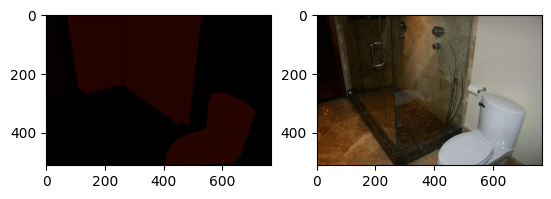

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ade20k_ds["validation"]["annotation"][0])
ax[1].imshow(ade20k_ds["validation"]["image"][0])
plt.show()

In [ ]:
#Set the swin checkpoint trained on ade20k
swin_checkpoint = "shi-labs/oneformer_ade20k_swin_large"

In [ ]:
#Processor
swin_processor = AutoProcessor.from_pretrained(swin_checkpoint,
                                               do_reduce_labels=True,
                                               ignore_index=255
                                               )

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
swin_processor.attributes

['image_processor', 'tokenizer']

In [ ]:
swin_processor.image_processor

OneFormerImageProcessor {
  "_max_size": 2560,
  "class_info_file": "ade20k_panoptic.json",
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "ignore_index": 255,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "OneFormerImageProcessor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "metadata": {
    "0": "wall",
    "1": "building",
    "10": "cabinet",
    "100": "poster, posting, placard, notice, bill, card",
    "101": "stage",
    "102": "van",
    "103": "ship",
    "104": "fountain",
    "105": "conveyer belt, conveyor belt, conveyer, conveyor, transporter",
    "106": "canopy",
    "107": "washer, automatic washer, washing machine",
    "108": "plaything, toy",
    "109": "pool",
    "11": "sidewalk, pavement",
    "110": "stool",
    "111": "barrel, cask",
    "112": "basket, handbasket",
    "113": "falls",
 

In [ ]:
swin_processor.tokenizer

CLIPTokenizerFast(name_or_path='shi-labs/oneformer_ade20k_swin_large', vocab_size=49408, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
#To create id2label
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_val.txt

--2024-01-09 11:00:27--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_val.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3221 (3.1K) [text/plain]
Saving to: ‘instanceInfo100_val.txt.1’

instanceInfo100_val 100%[===================>]   3.15K  --.-KB/s    in 0s      

2024-01-09 11:00:27 (38.5 MB/s) - ‘instanceInfo100_val.txt.1’ saved [3221/3221]



In [ ]:
import pandas as pd
data = pd.read_csv('/content/instanceInfo100_val.txt',
                   sep='\t', header=0, error_bad_lines=False)
data.head(5)

<ipython-input-13-358f74135363>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('/content/instanceInfo100_val.txt',


,Idx,Object Names,Unnamed: 2,#Inst.,#Pix. per Inst.(*1e3)
0,1,bed,229,53.14,NaN
1,2,windowpane,890,10.01,NaN
2,3,cabinet,690,13.27,NaN
3,4,person,2968,2.87,NaN
4,5,door,448,12.87,NaN


In [ ]:
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
print(id2label)

{0: 'bed', 1: 'windowpane', 2: 'cabinet', 3: 'person', 4: 'door', 5: 'table', 6: 'curtain', 7: 'chair', 8: 'car', 9: 'painting', 10: 'sofa', 11: 'shelf', 12: 'mirror', 13: 'armchair', 14: 'seat', 15: 'fence', 16: 'desk', 17: 'wardrobe', 18: 'lamp', 19: 'bathtub', 20: 'railing', 21: 'cushion', 22: 'box', 23: 'column', 24: 'signboard', 25: 'chest of drawers', 26: 'counter', 27: 'sink', 28: 'fireplace', 29: 'refrigerator', 30: 'stairs', 31: 'case', 32: 'pool table', 33: 'pillow', 34: 'screen door', 35: 'bookcase', 36: 'coffee table', 37: 'toilet', 38: 'flower', 39: 'book', 40: 'bench', 41: 'countertop', 42: 'stove', 43: 'palm', 44: 'kitchen island', 45: 'computer', 46: 'swivel chair', 47: 'boat', 48: 'arcade machine', 49: 'bus', 50: 'towel', 51: 'light', 52: 'truck', 53: 'chandelier', 54: 'awning', 55: 'streetlight', 56: 'booth', 57: 'television receiver', 58: 'airplane', 59: 'apparel', 60: 'pole', 61: 'bannister', 62: 'ottoman', 63: 'bottle', 64: 'van', 65: 'ship', 66: 'fountain', 67: 'w

In [ ]:
#model
swin_model = AutoModelForUniversalSegmentation.from_pretrained(swin_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
swin_model.config

OneFormerConfig {
  "_name_or_path": "shi-labs/oneformer_ade20k_swin_large",
  "architectures": [
    "OneFormerForUniversalSegmentation"
  ],
  "backbone_config": {
    "architectures": [
      "SwinForImageClassification"
    ],
    "depths": [
      2,
      2,
      18,
      2
    ],
    "drop_path_rate": 0.3,
    "embed_dim": 192,
    "hidden_size": 1536,
    "id2label": {
      "0": "tench, Tinca tinca",
      "1": "goldfish, Carassius auratus",
      "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
      "3": "tiger shark, Galeocerdo cuvieri",
      "4": "hammerhead, hammerhead shark",
      "5": "electric ray, crampfish, numbfish, torpedo",
      "6": "stingray",
      "7": "cock",
      "8": "hen",
      "9": "ostrich, Struthio camelus",
      "10": "brambling, Fringilla montifringilla",
      "11": "goldfinch, Carduelis carduelis",
      "12": "house finch, linnet, Carpodacus mexicanus",
      "13": "junco, snowbird",
      "14": "i

In [ ]:
swin_model.config.get_config_dict(swin_checkpoint)

({'_commit_hash': '4a5bac8e64f82681a12db2e151a4c2f4ce6092b2',
  'architectures': ['OneFormerForUniversalSegmentation'],
  'backbone_config': {'_name_or_path': '',
   'add_cross_attention': False,
   'architectures': ['SwinForImageClassification'],
   'attention_probs_dropout_prob': 0.0,
   'bad_words_ids': None,
   'begin_suppress_tokens': None,
   'bos_token_id': None,
   'chunk_size_feed_forward': 0,
   'cross_attention_hidden_size': None,
   'decoder_start_token_id': None,
   'depths': [2, 2, 18, 2],
   'diversity_penalty': 0.0,
   'do_sample': False,
   'drop_path_rate': 0.3,
   'early_stopping': False,
   'embed_dim': 192,
   'encoder_no_repeat_ngram_size': 0,
   'encoder_stride': 32,
   'eos_token_id': None,
   'exponential_decay_length_penalty': None,
   'finetuning_task': None,
   'forced_bos_token_id': None,
   'forced_eos_token_id': None,
   'hidden_act': 'gelu',
   'hidden_dropout_prob': 0.0,
   'hidden_size': 1536,
   'id2label': {'0': 'tench, Tinca tinca',
    '1': 'goldfi

In [ ]:
len(ade20k_ds["validation"]), ade20k_ds["validation"][0], np.unique(ade20k_ds["validation"][0]["annotation"]), ade20k_ds["validation"][0]["image"].size, ade20k_ds["validation"][0]["annotation"].size

(2000,
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x512>,
  'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x512>},
 array([ 0,  1,  2,  3,  4,  5, 35, 38], dtype=uint8),
 (768, 512),
 (768, 512))

In [ ]:
np.array(ade20k_ds["validation"][0]["image"].convert("RGB")).shape, np.array(ade20k_ds["validation"][0]["annotation"])[:, : , -1].shape

((512, 768, 3), (512, 768))

In [ ]:
# <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7C555BAC9450>
# <PIL.PngImagePlugin.PngImageFile image mode=L size=640x480 at 0x7C555BAC8130>

In [ ]:
np.array(ade20k_ds["validation"][0]["image"]).shape, np.array(ade20k_ds["validation"][0]["annotation"]).shape

((512, 768, 3), (512, 768, 3))

In [ ]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transforms = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transforms = A.Compose([
    A.Resize(width=512, height=512),
])

# val_transforms = A.Compose([
#     A.Resize(width=512, height=512),
#     A.Normalize(mean=ADE_MEAN, std=ADE_STD),
# ])

In [ ]:
#Create Custom Pytorch datatset for our ade20k
class CustomADE20KDataset(Dataset):
    def __init__(self, dataset, processor, transforms=None):
        self.dataset = dataset
        self.processor = processor
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # image = np.array(self.dataset[idx]["image"].convert("RGB"))
        image = np.array(self.dataset[idx]["image"].convert("RGB"))
        instance_seg_mask = np.array(self.dataset[idx]["annotation"])[:, :, 1] #Green channel
        class_id_map = np.array(self.dataset[idx]["annotation"])[:, :, 0] #Red Channel
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg_mask[class_id_map==label])
            inst2class.update({i: label for i in instance_ids})

        #apply transforms
        if self.transforms is not None:
            print("after")
            transformed = self.transforms(image=image, mask=instance_seg_mask)
            image = transformed["image"]
            image = image.transpose(2, 0, 1) # convert to C, H, W
            instance_seg_mask = transformed["mask"]
        print(type(image))
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor(images=[image], task_inputs=["instance"], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
            print("else")
            print(np.unique(image))
            print(np.unique(instance_seg_mask))
            # use processor to convert this instance seg mask to a list of binary masks, labels, text inputs and task inputs

            processed_inputs = self.processor(images=[image],
                                  segmentation_maps=[instance_seg_mask],
                                  task_inputs=["instance"],
                                  instance_id_to_semantic_id=inst2class,
                                  return_tensors="pt")
            print(type(image))
            processed_inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in processed_inputs.items()}

        return processed_inputs

In [ ]:
#single example evaluation
example = ade20k_ds["validation"][0]
image_d = np.array(example["image"]) #{image.min()}, {image.max()}


imagedummy = np.array(example["image"].convert("RGB"))
instance_seg_mask_dummy = np.array(example["annotation"])[:, :, 1]

print(imagedummy.min(), imagedummy.max())
print(instance_seg_mask_dummy.min(), instance_seg_mask_dummy.max())
print(imagedummy.dtype)
print(instance_seg_mask_dummy.dtype)

class_id_map_dummy = np.array(example["annotation"])[:, :, 0] #Red Channel
class_labels_dummy = np.unique(class_id_map_dummy)

inst2class_dummy = {}
for label in class_labels_dummy:
    instance_ids = np.unique(instance_seg_mask_dummy[class_id_map_dummy==label])
    inst2class_dummy.update({i: label for i in instance_ids})

transformed_dummy = val_transforms(image=imagedummy, mask=instance_seg_mask_dummy)
imagedummy = transformed_dummy["image"]
imagedummy = imagedummy.transpose(2, 0, 1) # convert to C, H, W
instance_seg_mask_dummy = transformed_dummy["mask"]
print(f"transformed:{imagedummy.shape}")
print(f"transformed:{instance_seg_mask_dummy.shape}")

#processor
swin_processor.image_processor.num_text = swin_model.config.num_queries - swin_model.config.text_encoder_n_ctx
processed_inputs_dummy = swin_processor(images=[imagedummy],
                                #   segmentation_maps=[instance_seg_mask_dummy], #this switch the image processing of masks. during eval no need to send masks.othwrise it enables the mask preprocessing and issues with it will come up
                                  task_inputs=["instance"],
                                  instance_id_to_semantic_id=inst2class_dummy,
                                  return_tensors="pt")
processed_inputs_dummy = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k, v in processed_inputs_dummy.items()}
print(processed_inputs_dummy.keys())

for k,v in processed_inputs_dummy.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)
    else:
        print(k, len(v))

#Note that for custom datasets, you'll need to set 2 attributes of the processor's image processor,
#namely repo_path and class_info_file, which point to a metadata file on the 🤗 hub. This allows the processor to know the names of the individual classes.
#example file: https://huggingface.co/datasets/shi-labs/oneformer_demo/blob/main/ade20k_panoptic.json

#add the batch dimension
processed_inputs_dummy = {k: v.unsqueeze(0) for k,v in processed_inputs_dummy.items()}
for k,v in processed_inputs_dummy.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)
    else:
        print(k, len(v))


swin_model.eval()
swin_model.model.is_training = False #switch off the contrastive loss
with torch.inference_mode():
    outputs = swin_model(**processed_inputs_dummy)

#postprocessing
semantic_segmentation = swin_processor.post_process_semantic_segmentation(outputs, target_sizes=[image_d.size[::-1]])[0]
semantic_segmentation


0 255
0 4
uint8
uint8
transformed:(3, 512, 512)
transformed:(512, 512)
dict_keys(['pixel_values', 'pixel_mask', 'task_inputs'])
pixel_values torch.Size([3, 640, 640])
pixel_mask torch.Size([640, 640])
task_inputs torch.Size([77])
pixel_values torch.Size([1, 3, 640, 640])
pixel_mask torch.Size([1, 640, 640])
task_inputs torch.Size([1, 77])


In [ ]:
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import requests
import torch

# load OneFormer fine-tuned on ADE20k for universal segmentation
processor = OneFormerProcessor.from_pretrained(swin_checkpoint)
model = OneFormerForUniversalSegmentation.from_pretrained(swin_checkpoint)
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx

class CustomADE20KDataset(Dataset):
    def __init__(self, dataset, processor, transforms=None):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"].convert("RGB"))
        instance_seg_mask = np.array(self.dataset[idx]["annotation"])[:, :, 1] #Green channel
        class_id_map = np.array(self.dataset[idx]["annotation"])[:, :, 0] #Red Channel
        class_labels = np.unique(class_id_map)
        print(image.shape)
        print(instance_seg_mask.shape)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg_mask[class_id_map==label])
            inst2class.update({i: label for i in instance_ids})

        processed_inputs = self.processor(images=[image],
                                        #   segmentation_maps=[instance_seg_mask],
                                          task_inputs=["instance"],
                                          return_tensors="pt")
        processed_inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in processed_inputs.items()}
        return processed_inputs

val_dataset = CustomADE20KDataset(dataset=ade20k_ds["validation"],
                                  processor=processor)

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    task_inputs = torch.stack([example["task_inputs"] for example in batch])
    return {"pixel_values": pixel_values,
            "pixel_mask": pixel_mask,
            "task_inputs": task_inputs}

val_dataloader = DataLoader(val_dataset,
                            batch_size=2,
                            shuffle=False,
                            collate_fn=collate_fn
                            )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.to(device)

with torch.inference_mode():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        print(batch.keys())
        batch = {k: v.to(device) for k, v in batch.items()}
        # Forward pass
        outputs = swin_model(**batch)
        class_queries_logits = outputs.class_queries_logits
        masks_queries_logits = outputs.masks_queries_logits

        del batch
        break

  0%|          | 0/2000 [00:00<?, ?it/s]

(512, 768, 3)
(512, 768)
dict_keys(['pixel_values', 'pixel_mask', 'task_inputs'])


In [ ]:
class_queries_logits.shape, masks_queries_logits.shape
class

(torch.Size([1, 250, 151]), torch.Size([1, 250, 160, 240]))

In [ ]:
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import requests
import torch

# load OneFormer fine-tuned on ADE20k for universal segmentation
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")

url = ("https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg")
image = Image.open(requests.get(url, stream=True).raw)

# # Semantic Segmentation
# inputs = processor(image, ["semantic"], return_tensors="pt")

# with torch.no_grad():
#     outputs = model(**inputs)
#     # model predicts class_queries_logits of shape `(batch_size, num_queries)`
#     # and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
#     class_queries_logits = outputs.class_queries_logits
#     masks_queries_logits = outputs.masks_queries_logits

#     # you can pass them to processor for semantic postprocessing
#     predicted_semantic_map = processor.post_process_semantic_segmentation(
#         outputs, target_sizes=[image.size[::-1]])[0]

#     print(f"Semantic Predictions Shape: {list(predicted_semantic_map.shape)}")

# Instance Segmentation
inputs = processor(image, ["instance"], return_tensors="pt")
print(inputs)
with torch.no_grad():
    outputs = model(**inputs)
    # model predicts class_queries_logits of shape `(batch_size, num_queries)`
    # and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    # you can pass them to processor for instance postprocessing
    predicted_instance_map = processor.post_process_instance_segmentation(
        outputs, target_sizes=[image.size[::-1]])[0]["segmentation"]
    print(f"Instance Predictions Shape: {list(predicted_instance_map.shape)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


{'pixel_values': tensor([[[[-0.6452, -0.6623, -0.6623,  ..., -0.7822, -0.7822, -0.7822],
          [-0.6452, -0.6623, -0.6623,  ..., -0.7822, -0.7822, -0.7822],
          [-0.6452, -0.6623, -0.6623,  ..., -0.7822, -0.7822, -0.7822],
          ...,
          [-0.5938, -0.5424, -0.5424,  ..., -0.1657, -0.1657, -0.1486],
          [-0.5082, -0.4911, -0.5082,  ..., -0.1143, -0.0972, -0.0801],
          [-0.5082, -0.5082, -0.5596,  ..., -0.1143, -0.0972, -0.0801]],

         [[ 0.3803,  0.3627,  0.3627,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.3803,  0.3627,  0.3627,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.3803,  0.3627,  0.3627,  ...,  0.2227,  0.2227,  0.2227],
          ...,
          [-0.3550, -0.3025, -0.3025,  ..., -0.0924, -0.0924, -0.0749],
          [-0.2850, -0.2675, -0.2850,  ..., -0.0399, -0.0224, -0.0049],
          [-0.2850, -0.2850, -0.3375,  ..., -0.0399, -0.0224, -0.0049]],

         [[ 1.4374,  1.4200,  1.4548,  ...,  1.4374,  1.4374,  1.4374],
          [ 1

In [ ]:
swin_processor.image_processor.num_text = swin_model.config.num_queries - swin_model.config.text_encoder_n_ctx
# val_dataset = CustomADE20KDataset(dataset=ade20k_ds["validation"],
#                                   processor=swin_processor)
val_dataset = CustomADE20KDataset(dataset=ade20k_ds["validation"],
                                  processor=swin_processor,
                                  transforms=val_transforms)

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    text_inputs = torch.stack([example["text_inputs"] for example in batch])
    task_inputs = torch.stack([example["task_inputs"] for example in batch])
    return {"pixel_values": pixel_values,
            "pixel_mask": pixel_mask,
            "class_labels": class_labels,
            "mask_labels": mask_labels,
            "task_inputs": task_inputs,
            "text_inputs": text_inputs}

val_dataloader = DataLoader(val_dataset,
                            batch_size=2,
                            shuffle=False,
                            collate_fn=collate_fn)
# val_dataloader = DataLoader(val_dataset,
#                             batch_size=2,
#                             shuffle=False
#                             )

In [ ]:
#Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.to(device)

# swin_model.model.is_training = False
running_loss = 0.0


swin_model.eval()
swin_model.model.is_training = False
for idx, batch in enumerate(tqdm(val_dataloader)):
    batch = {k: v.to(device) for k, v in batch.items()}
    # Forward pass
    outputs = swin_model(**batch)

    eval_loss = outputs.loss
    running_loss += eval_loss.item()

    # results = swin_processor.post_process_instance_segmentation(outputs=outputs, target_sizes=[image.size[::-1]]) # convert outputs to COCO api
    # res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    # coco_evaluator.update(res)
    del batch

In [ ]:
#Evaluation should be done using coco evaluator